# Laboratorio 2



### Integrantes
- Juan Nicolas Suarez Pulido  - 202222678 - jn.suarez
- David Santiago Carrillo Vargas - 202225276 - d.carrillov
- Mauricio Martinez Urbaneja - 202314461 - m.martinezu

# Objetivo del negocio

SeneCafeAlpes necesita garantizar la uniformidad y trazabilidad de sus granos, ya que la heterogeneidad en tamaño, forma y estructura puede afectar tanto los procesos de tostión como la percepción de calidad del consumidor final.

**Garantizar control de calidad**, estandarizando la clasificación y selección de granos para asegurar uniformidad en el proceso de tostión y consistencia en la experiencia del consumidor.

**Optimizar el posicionamiento en el mercado**, comprendiendo las agrupaciones naturales de las variedades para diseñar nuevas mezclas con mayor valor agregado y diferenciación comercial.

**Innovar en trazabilidad**, desarrollando bases para sistemas automáticos de identificación de variedades que reduzcan la dependencia de evaluaciones manuales y aumenten la transparencia en toda la cadena de valor.

## 1. Carga de librerias

In [2]:
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats

from sklearn.cluster import KMeans


## 1.1 Carga de datos

In [3]:
df = pd.read_csv("./data/Datos_SenecaféAlpes.csv", sep=";", encoding="utf-8-sig")

df.head(5)

,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
0,G006149,50836,923618.0,358.515147,181.388899,alargado,NaN,NaN,254.413847,0.804762,0.983840,0.748853,0.709632,0.007052,0.001103,0.503578,0.995321,Normal,Lavado
1,G007234,62764,1003767.0,409.207082,198.330199,Alargado,NaN,64158.0,282.689948,0.703995,0.978272,0.782807,0.690824,0.006520,0.000916,0.477237,0.984666,NaN,Natural
2,G007054,59965,994266.0,389.088529,197.967275,Alargado,0.860886,60910.0,276.314692,0.661581,0.984485,0.762259,0.710159,0.006489,0.001018,0.504326,0.991211,Normal,Natural
3,G006619,55035,917.6,379.346822,185.390577,Alargado,0.872446,55591.0,NaN,0.799695,0.989998,0.821376,0.697811,0.006893,0.001008,0.486941,0.996380,Normal,Lavado
4,G013353,39324,737773.0,262.520242,191.176858,Alargado,0.685326,39758.0,223.760747,0.775392,0.989084,0.907867,0.852356,0.006676,0.002174,0.726511,0.997630,Normal,Lavado


In [4]:
df.shape

(14291, 19)

# 2. Calidad de los datos

Se llevará a cabo una revisión integral de la calidad de los datos de café entregados, evaluando aspectos clave como completitud, duplicidad, consistencia y estandarización. Este análisis permitirá garantizar que la información se encuentre en condiciones óptimas para su posterior procesamiento y análisis.


# 2.1 Completitud

In [5]:
porcentajes=  df.isnull().sum() / len(df) * 100

completitud = pd.DataFrame({
    "Cantidad": df.isnull().sum(),
    "Porcentaje": porcentajes.round(2),
    "Porcentaje (%)": porcentajes.round(2).astype(str).add("%")
}).sort_values(by="Porcentaje", ascending=False)

completitud

,Cantidad,Porcentaje,Porcentaje (%)
DefectoVisible,2935,20.54,20.54%
Solidez,2306,16.14,16.14%
Redondez,2063,14.44,14.44%
DiametroEquivalente,1923,13.46,13.46%
AreaConvexa,1423,9.96,9.96%
Perimetro,1237,8.66,8.66%
FactorForma4,1159,8.11,8.11%
FactorForma1,1119,7.83,7.83%
FactorForma2,1106,7.74,7.74%
Compacidad,650,4.55,4.55%


En el dataset se observa que variables como DefectoVisible y Solidez presentan porcentajes elevados de valores ausentes, mientras que otras como Área o LongitudEjeMayor prácticamente no tienen faltantes. Pero ya que hay tantas variables faltantes , y no todas de las mismas filas , no se pueden eliminar todos los duplicados.

# 2.1 Duplicidad

Primero se revisara que no se repita el id del cafe , ya que este debe ser unico.

In [6]:
df.duplicated().sum()

np.int64(461)

In [7]:
duplicados_cafe = df.duplicated(subset=['ID']).sum()
print(f"Cantidad de filas duplicadas en 'ID': {duplicados_cafe}")

Cantidad de filas duplicadas en 'ID': 680


Según el diccionario de datos, esta columna corresponde a un identificador único. Por lo tanto, la presencia de registros duplicados indica inconsistencias que deben corregirse. Para evitar sesgos en los resultados del proceso de agrupación, dichos duplicados serán eliminados del conjunto de datos.

In [8]:
print(f"Cantidad de muestras con duplicados en columna ID: {len(df)}")
df = df.drop_duplicates(subset=['ID'])
print(f"Cantidad de muestras sin duplicados en columna ID: {len(df)}")

Cantidad de muestras con duplicados en columna ID: 14291
Cantidad de muestras sin duplicados en columna ID: 13611


# 2.2 Consistencia 

Primero revisaremos las consistencias de las variables categoricas (Relacion_Aspecto , Defecto Visible y Metodo de secado).

## 2.2.1 Variables categoricas

### Variable Relacion Aspecto

In [9]:
df['RelacionAspecto'].value_counts()

RelacionAspecto
Alargado      11471
Redondeado     1658
alargado         29
redondeado       10
Name: count, dtype: int64

Existen inconsistencias entre estas , para que se agrupe los datos como deberia ser transformaran los datos

In [10]:

def transformarRelacionAspecto(value):
    if pd.isna(value):
        return value
    value = str(value).strip().lower()
    mapping = { 'alargado':'Alargado','redondeado':'Redondeado'}
    return mapping.get(value, value.title())

df['RelacionAspecto'] = df['RelacionAspecto'].apply(transformarRelacionAspecto)
df['RelacionAspecto'].value_counts()

RelacionAspecto
Alargado      11500
Redondeado     1668
Name: count, dtype: int64

### Variable Defecto Visible

In [11]:
df['DefectoVisible'].value_counts()

DefectoVisible
Normal    8654
normal    2176
Name: count, dtype: int64

Esta columna tiene todos los mismos valores , entonces no le aporta nada al modelo . Por lo que se eliminara.

# Variable Metodo de Secado

In [12]:
df['MétodoSecado'].value_counts()

MétodoSecado
Lavado     5922
Natural    4450
lavado     1477
natural    1129
Honey        62
honey        13
Name: count, dtype: int64

In [13]:
def transformarMetodoSecado(value):
    if pd.isna(value):
        return value
    value = str(value).strip().lower()
    mapping = {'lavado':'Lavado','natural':'Natural','honey':'Honey'}
    return mapping.get(value, value.title())

df['MétodoSecado'] = df['MétodoSecado'].apply(transformarMetodoSecado)
df['MétodoSecado'].value_counts()

MétodoSecado
Lavado     7399
Natural    5579
Honey        75
Name: count, dtype: int64

## 2.2.2 Variables numericas

In [14]:
df.describe()

,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4
count,13611.000000,1.242900e+04,13226.000000,13611.000000,13047.000000,12246.000000,11786.000000,13611.000000,11426.000000,11635.000000,12984.000000,12542.000000,12572.000000,13156.000000,12507.000000
mean,53028.124679,7.718032e+05,319.846273,202.156493,0.749759,53573.334395,253.010402,0.749615,0.986749,0.873142,0.799355,0.006561,0.001713,0.643330,0.994255
std,29360.538712,3.273589e+05,86.296919,45.480837,0.099858,29523.643323,60.267674,0.050847,0.026556,0.061346,0.067890,0.001162,0.000601,0.100867,0.040034
min,-62716.000000,-1.012143e+06,-421.444657,-200.838672,-0.835004,-78423.000000,-448.402605,-0.798706,-0.989042,-0.773494,-0.843901,-0.007982,-0.002673,-0.683269,-0.998527
25%,36323.500000,6.764180e+05,253.254970,175.804945,0.715165,36713.000000,215.249232,0.718629,0.985591,0.832772,0.762243,0.005899,0.001153,0.581209,0.993677
50%,44651.000000,7.718510e+05,296.521397,192.426859,0.764141,45103.000000,238.570152,0.759847,0.988275,0.883347,0.801161,0.006646,0.001692,0.641928,0.996386
75%,61330.000000,9.548440e+05,376.467868,217.031741,0.810369,62160.500000,279.682724,0.786849,0.989987,0.916778,0.834396,0.007275,0.002169,0.696223,0.997891
max,254616.000000,1.921685e+06,738.860154,460.198497,0.911423,251082.000000,569.374358,0.866195,0.994378,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


### Variables Continuas

Como se puede ver , en muchos de las variables tenemos minimos negativos que para la logica no tendrian sentido . Por lo que se deben eliminar

In [15]:
# Variables que no pueden tener valores negativos
no_negative = ["Area", "Perimetro", "LongitudEjeMayor", "LongitudEjeMenor", "AreaConvexa", "DiametroEquivalente"
               ,'Excentricidad','Redondez']

# Elimina todas las filas que no deben tener negativos
df = df[(df[no_negative] >= 0).all(axis=1)]

mask_invalido = pd.Series(False, index=df.index)

# Regla 1: Área ≤ Área Convexa
if {"Area", "AreaConvexa"}.issubset(df.columns):
    mask_invalido |= df["Area"] > df["AreaConvexa"]

# Regla 2: LongitudEjeMenor ≤ LongitudEjeMayor
if {"LongitudEjeMenor", "LongitudEjeMayor"}.issubset(df.columns):
    mask_invalido |= df["LongitudEjeMenor"] > df["LongitudEjeMayor"]

# Filtrar solo válidos
df_validos = df[~mask_invalido]
df = df_validos.copy()


In [16]:
df.describe()

,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4
count,7616.000000,7.616000e+03,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,7616.000000,6374.000000,7616.000000,7283.000000,7049.000000,7039.000000,7351.000000,7003.000000
mean,52861.477941,7.695805e+05,319.413230,202.159440,0.750048,53577.651654,252.717896,0.750176,0.986798,0.873825,0.800106,0.006558,0.001720,0.644438,0.994821
std,28921.168254,3.234590e+05,85.015434,44.545604,0.091862,29367.672565,58.646746,0.051529,0.025169,0.059067,0.066870,0.001176,0.000598,0.100857,0.024186
min,20420.000000,5.536000e+02,183.601165,122.512653,0.218951,20684.000000,161.243764,-0.798706,-0.987408,0.489618,-0.827971,-0.007982,-0.002157,-0.683269,-0.995589
25%,36291.250000,6.763355e+05,252.965580,176.169664,0.714590,36676.000000,214.959193,0.719851,0.985678,0.833541,0.763613,0.005906,0.001160,0.583669,0.993765
50%,44537.000000,7.690460e+05,295.915641,192.528246,0.763830,45050.500000,238.130783,0.760675,0.988259,0.883935,0.801764,0.006644,0.001701,0.642988,0.996427
75%,61131.000000,9.545372e+05,375.752750,216.305553,0.809335,62115.750000,278.988183,0.786893,0.989986,0.917116,0.834820,0.007266,0.002180,0.697180,0.997911
max,248424.000000,1.884557e+06,721.216098,460.198497,0.908167,251082.000000,562.408446,0.866195,0.994082,0.986812,0.987303,0.010451,0.003564,0.974767,0.999709


### Variables con rangos definidos

- Relacion aspecto no puede ser Alargado > 1.3 y Redondeado <= 1.3.
- Excentricidad , redondez deben tener rango de 0 a 1. 


In [17]:
# Calcular la clasificación según la regla numérica
df["CheckForma"] = (df["LongitudEjeMayor"] / df["LongitudEjeMenor"]).apply(
    lambda x: "Alargado" if x > 1.3 else "Redondeado"
)

# Comparar con la columna original
df["Coincide"] = df["RelacionAspecto"] == df["CheckForma"]

# Resumen de coincidencias
print(df["Coincide"].value_counts())
print("Porcentaje de coincidencias:", df["Coincide"].mean() * 100, "%")

df = df.drop(columns=["CheckForma", "Coincide"])


Coincide
True     7388
False     228
Name: count, dtype: int64
Porcentaje de coincidencias: 97.00630252100841 %


Revisando la regla de negocio , no concuerda la diferencia de longitudEjeMayor y LongitudEjeMenor con la relacion aspecto.

Por lo que se sobreescribira los datos , con la regla de negocio dada en el diccionario.

In [18]:
df["RelacionAspecto"] = (df["LongitudEjeMayor"] / df["LongitudEjeMenor"]).apply(
    lambda x: "Alargado" if x > 1.3 else "Redondeado"
)

# 2.3 Estandarizacion

## Conversion de variables categoricas

Se transforma las categoricas a numericas ya que  la mayoría de algoritmos de análisis y clustering operan con números: calculan distancias, promedios y varianzas. Las categorías como “Lavado” o “Honey” no tienen una distancia definida entre sí hasta que se codifican numéricamente (p. ej., one-hot). Al transformarlas evitas introducir orden falso, haces posible la estandarización y mejoras la interpretabilidad y reproducibilidad de los resultados.

### 2.3.1 Conversion de relacion de aspecto a binaria

In [19]:
# Mapear la relación de aspecto a binario
df["RelacionAspecto"] = df["RelacionAspecto"].map({"Alargado": 1, "Redondeado": 0})


### 2.3.2 Conversion de Metodo de secado con One Hot Encoding

In [20]:
# One-Hot solo para MétodoSecado
df = pd.get_dummies(df, columns=["MétodoSecado"], prefix="Secado")
df

,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,Secado_Honey,Secado_Lavado,Secado_Natural
2,G007054,59965,994266.00,389.088529,197.967275,1,0.860886,60910.0,276.314692,0.661581,0.984485,0.762259,0.710159,0.006489,0.001018,0.504326,0.991211,Normal,False,False,True
4,G013353,39324,737773.00,262.520242,191.176858,1,0.685326,39758.0,223.760747,0.775392,0.989084,0.907867,0.852356,0.006676,0.002174,0.726511,0.997630,Normal,False,True,False
5,G006127,50654,879938.00,357.233899,181.407743,1,0.861468,51251.0,253.958020,0.634857,0.988351,0.822090,0.710901,0.007052,0.001111,NaN,0.995211,NaN,False,False,True
10,G001140,39948,731068.00,244.969135,207.964148,0,0.528489,40386.0,225.529096,0.772032,0.989155,0.939268,0.920643,0.006132,0.002717,0.847583,0.998402,Normal,False,True,False
11,G007741,39392,746.64,265.915971,189.144664,1,0.702894,39836.0,223.954130,0.725291,0.988854,0.887964,0.842199,0.006751,0.002095,0.709299,0.997194,Normal,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14284,G011285,29882,649082.00,247.427847,154.779257,1,0.780182,30213.0,195.056259,0.671430,0.989044,0.891293,0.788336,0.008280,0.001973,0.621474,0.993478,NaN,False,False,True
14285,G011965,32384,657952.00,238.548336,173.086148,1,0.688137,32711.0,203.058094,0.755841,0.990003,0.940052,0.851224,0.007366,0.002386,0.724582,0.998624,Normal,False,True,False
14286,G005192,83266,1117778.00,448.473710,237.747098,1,0.847920,84030.0,325.603384,0.797239,0.990908,0.837465,0.726026,0.005386,0.000923,0.527113,0.994319,NaN,False,True,False
14287,G013419,39857,755392.00,283.623668,179.430885,1,0.774448,40330.0,225.272077,0.692154,0.988272,0.877748,0.794264,0.007116,0.001747,0.630855,0.997183,Normal,False,False,True


# 3 Perfilamiento de los Datos

## 3.1 Eliminacion de columnas no necesarias para el modelo

Como habiamos visto Defecto visible solo tiene un valor "Normal" y ya que no hay muestras con valor "Defectuoso" no aporta a nuestro modelo. 

Ademas ID tampoco aporta al modelo pero sirivio para comprobar duplicados.

In [21]:
df= df.drop(columns=["DefectoVisible", "ID"] ,axis=1)
df

,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,Secado_Honey,Secado_Lavado,Secado_Natural
2,59965,994266.00,389.088529,197.967275,1,0.860886,60910.0,276.314692,0.661581,0.984485,0.762259,0.710159,0.006489,0.001018,0.504326,0.991211,False,False,True
4,39324,737773.00,262.520242,191.176858,1,0.685326,39758.0,223.760747,0.775392,0.989084,0.907867,0.852356,0.006676,0.002174,0.726511,0.997630,False,True,False
5,50654,879938.00,357.233899,181.407743,1,0.861468,51251.0,253.958020,0.634857,0.988351,0.822090,0.710901,0.007052,0.001111,NaN,0.995211,False,False,True
10,39948,731068.00,244.969135,207.964148,0,0.528489,40386.0,225.529096,0.772032,0.989155,0.939268,0.920643,0.006132,0.002717,0.847583,0.998402,False,True,False
11,39392,746.64,265.915971,189.144664,1,0.702894,39836.0,223.954130,0.725291,0.988854,0.887964,0.842199,0.006751,0.002095,0.709299,0.997194,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14284,29882,649082.00,247.427847,154.779257,1,0.780182,30213.0,195.056259,0.671430,0.989044,0.891293,0.788336,0.008280,0.001973,0.621474,0.993478,False,False,True
14285,32384,657952.00,238.548336,173.086148,1,0.688137,32711.0,203.058094,0.755841,0.990003,0.940052,0.851224,0.007366,0.002386,0.724582,0.998624,False,True,False
14286,83266,1117778.00,448.473710,237.747098,1,0.847920,84030.0,325.603384,0.797239,0.990908,0.837465,0.726026,0.005386,0.000923,0.527113,0.994319,False,True,False
14287,39857,755392.00,283.623668,179.430885,1,0.774448,40330.0,225.272077,0.692154,0.988272,0.877748,0.794264,0.007116,0.001747,0.630855,0.997183,False,False,True


### 3.2 Analisis numerico

A continuación se seleccionan las variables numéricas del dataset, que corresponden a las medidas geométricas y morfológicas de los granos de café. Estas variables serán la base para la aplicación de los algoritmos de agrupación, ya que contienen la información cuantitativa relevante.


In [22]:
numericas = [
    'Area', 'Perimetro', 'LongitudEjeMayor', 'LongitudEjeMenor',
    'Excentricidad', 'AreaConvexa', 'DiametroEquivalente', 'Medida',
    'Solidez', 'Redondez', 'Compacidad',
    'FactorForma1', 'FactorForma2', 'FactorForma3', 'FactorForma4','RelacionAspecto'
]

print("Número de variables numéricas seleccionadas:", len(numericas))
print(numericas[:8], "...")


Número de variables numéricas seleccionadas: 16
['Area', 'Perimetro', 'LongitudEjeMayor', 'LongitudEjeMenor', 'Excentricidad', 'AreaConvexa', 'DiametroEquivalente', 'Medida'] ...


### 3.3 Distribucion de las variables

### 3.3.1 Gráficas de dispersión

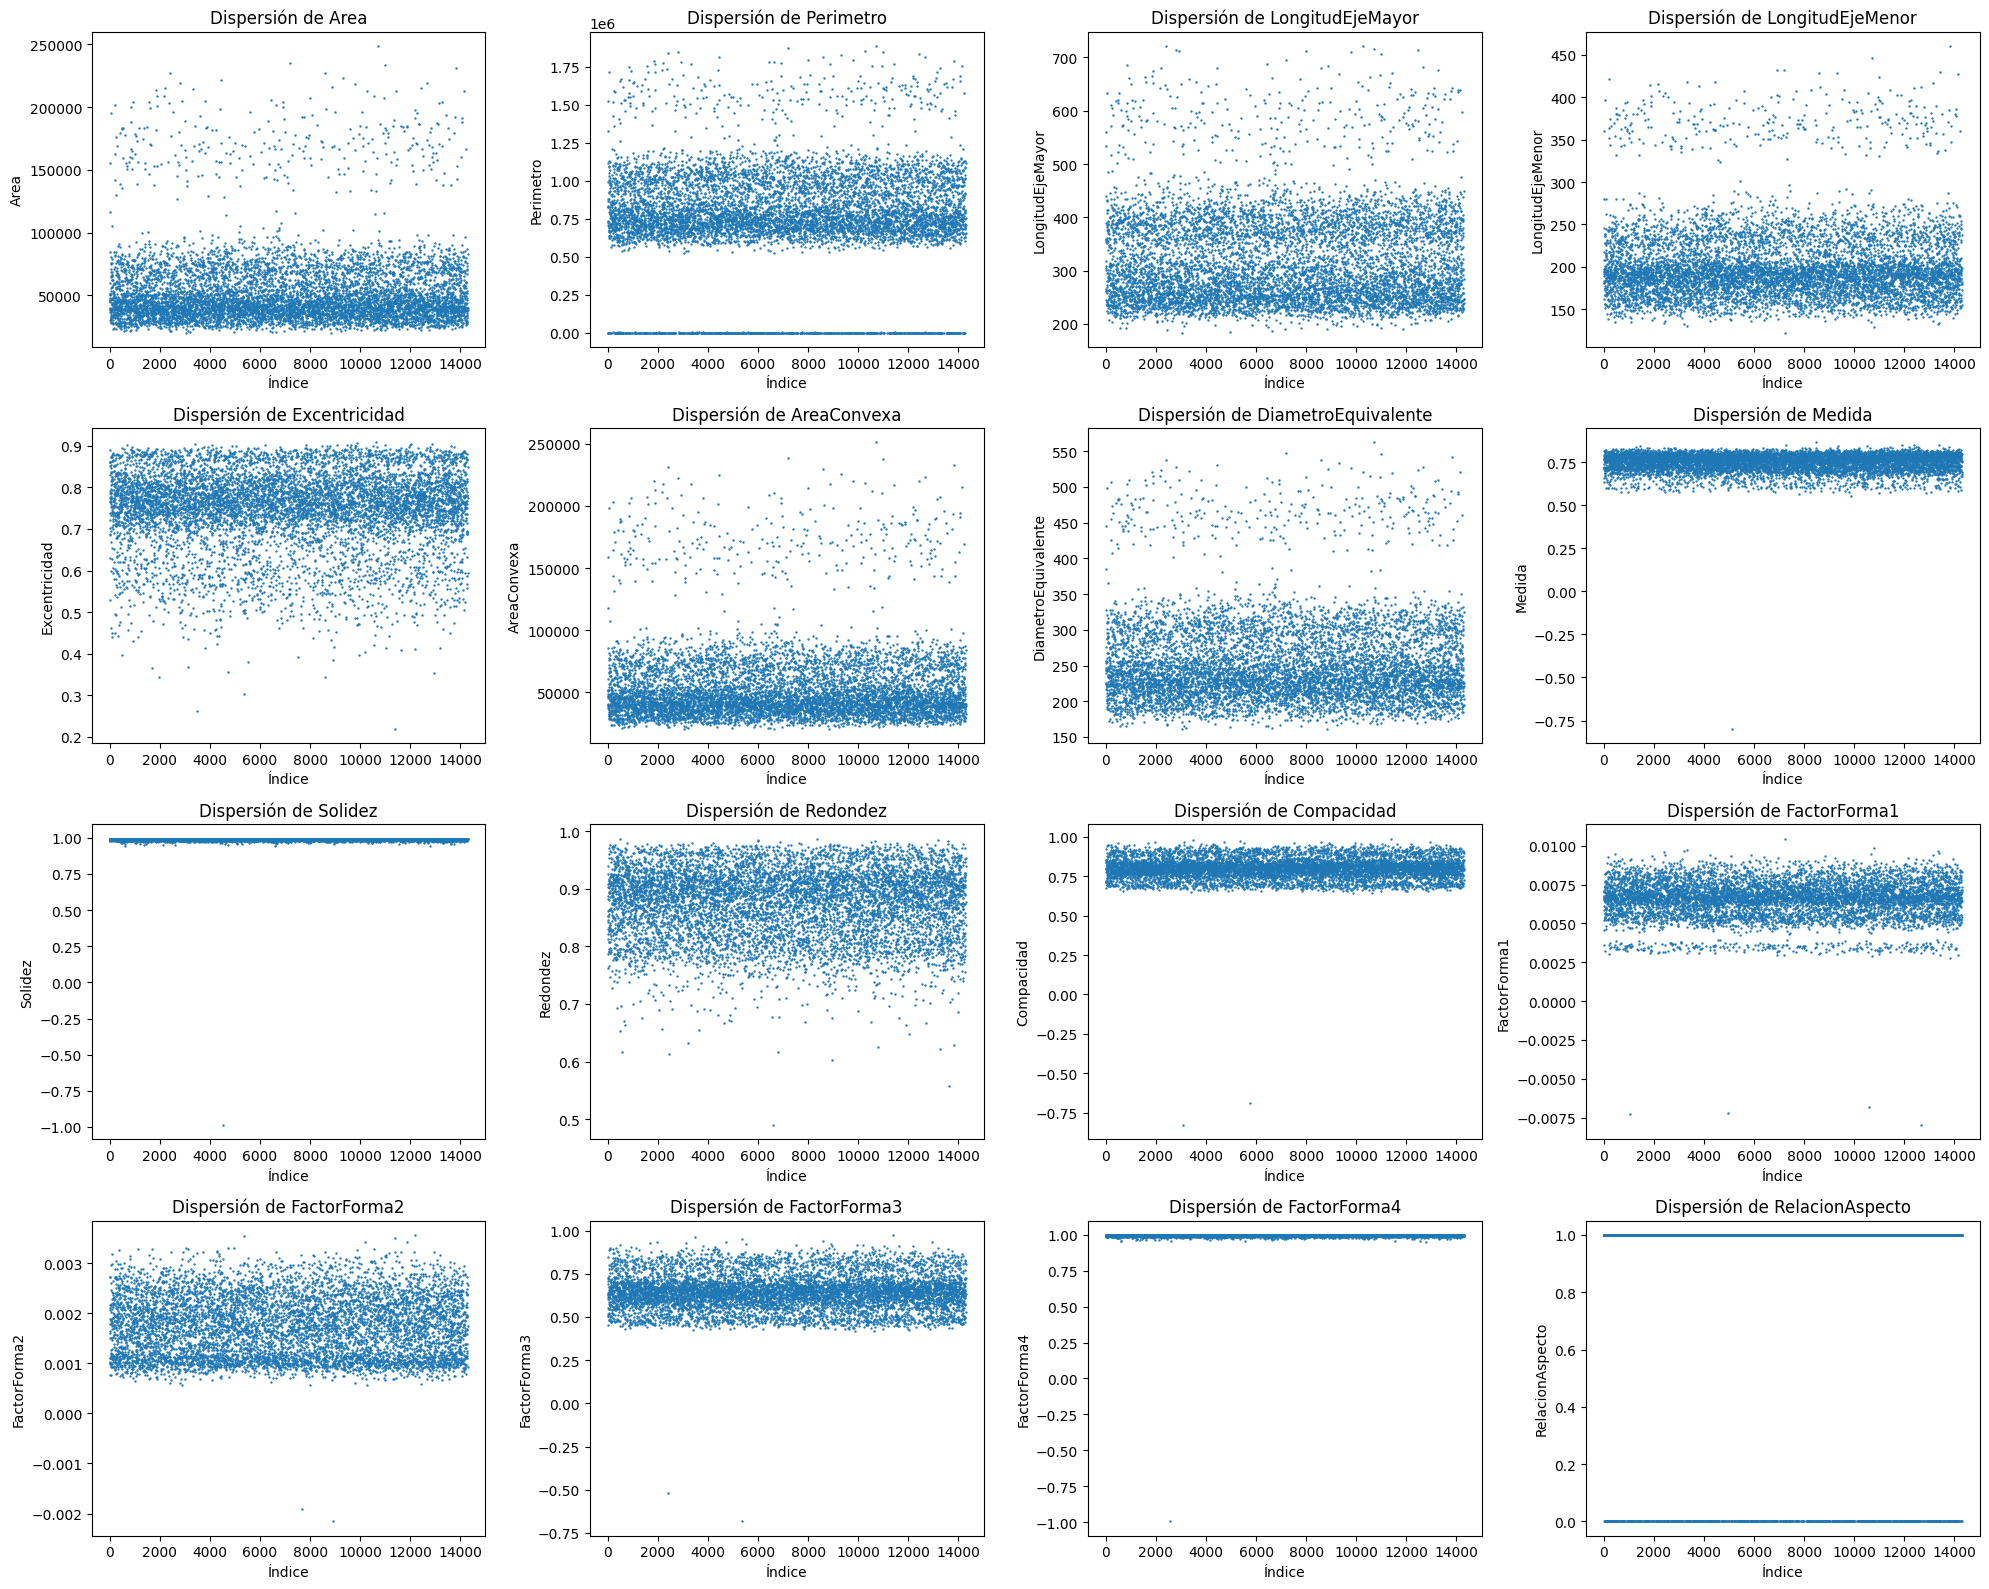

In [23]:
import math

columnas_por_fila = 4
filas = math.ceil(len(numericas) / columnas_por_fila)
fig, ejes = plt.subplots(filas, columnas_por_fila, figsize=(columnas_por_fila * 5, filas * 4))
ejes = ejes.flatten()

for eje, columna in zip(ejes, numericas):
    eje.scatter(df.index, df[columna], s=0.5)
    eje.set_xlabel("Índice")
    eje.set_ylabel(columna)
    eje.set_title(f"Dispersión de {columna}")

for eje in ejes[len(numericas):]:
    eje.set_visible(False)

plt.tight_layout()
plt.show()


### 3.3.2 Histogramas y Boxplots

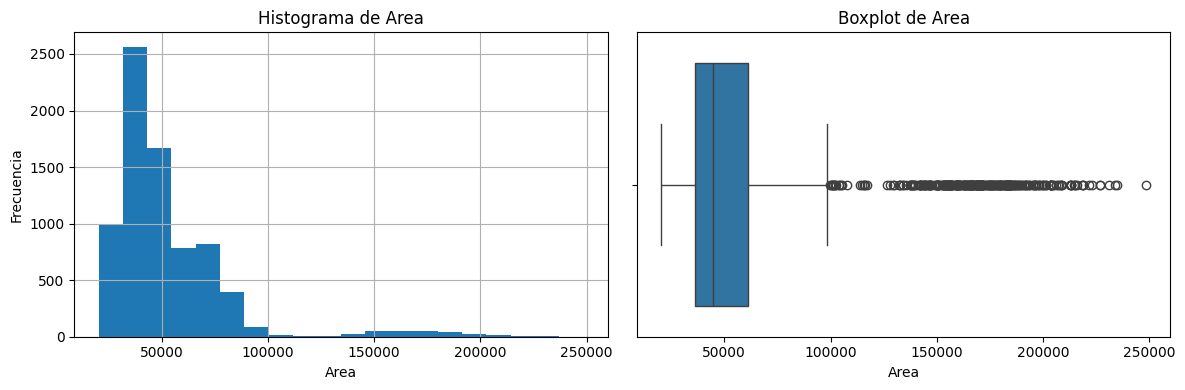

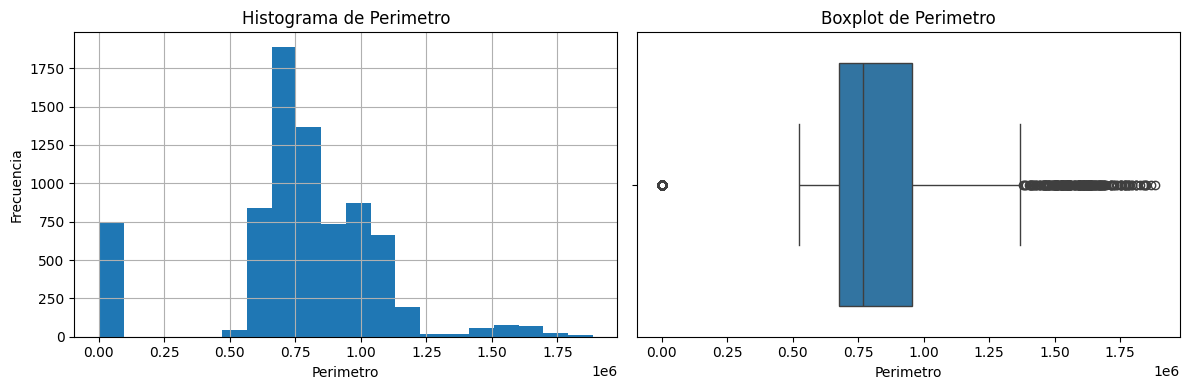

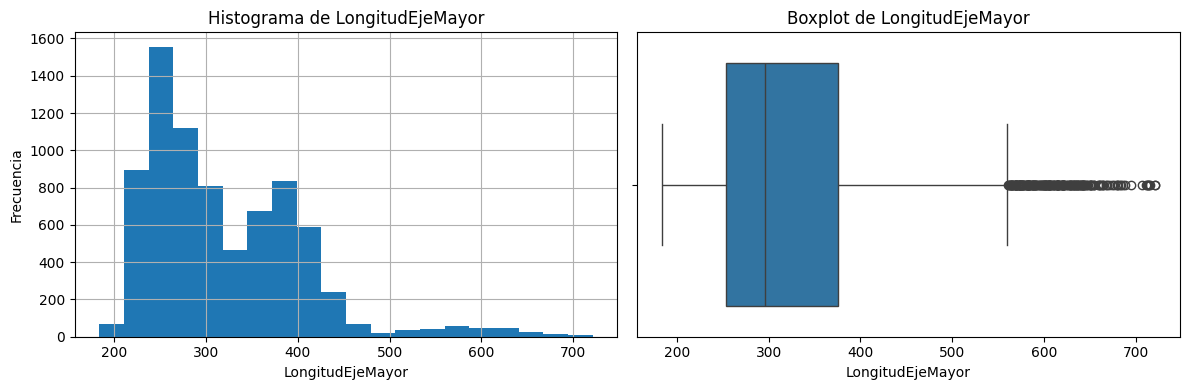

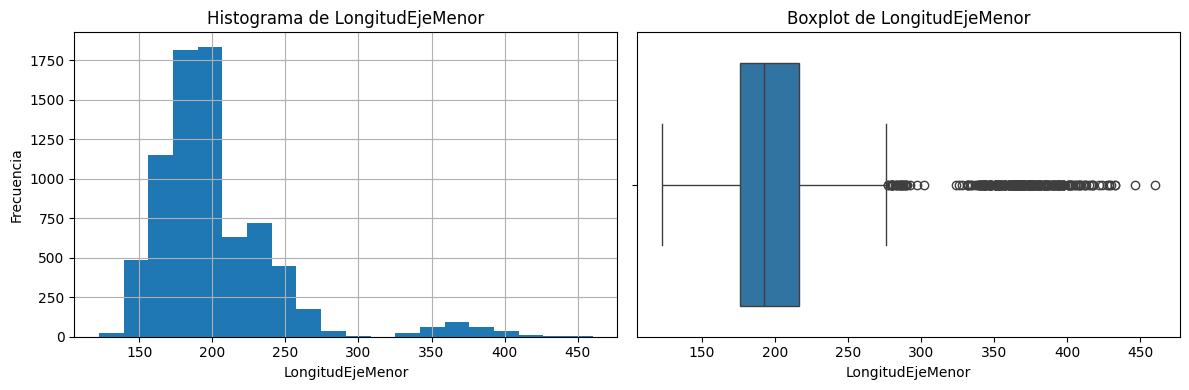

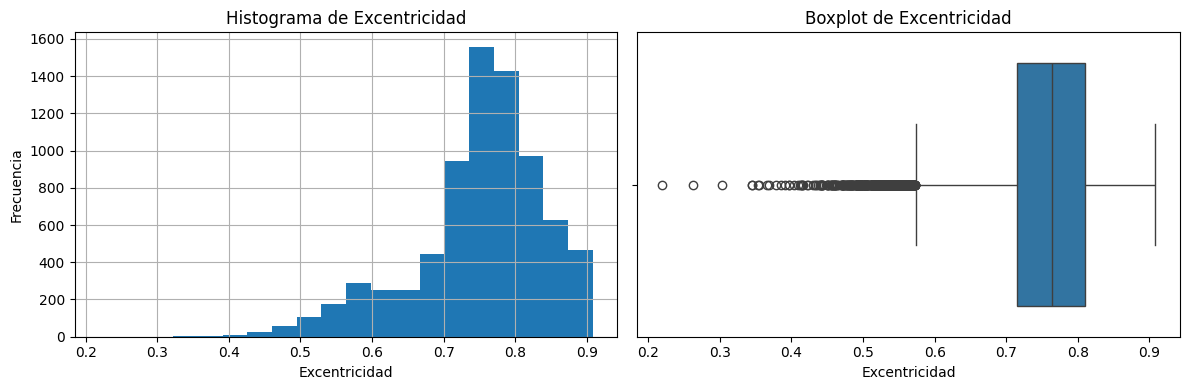

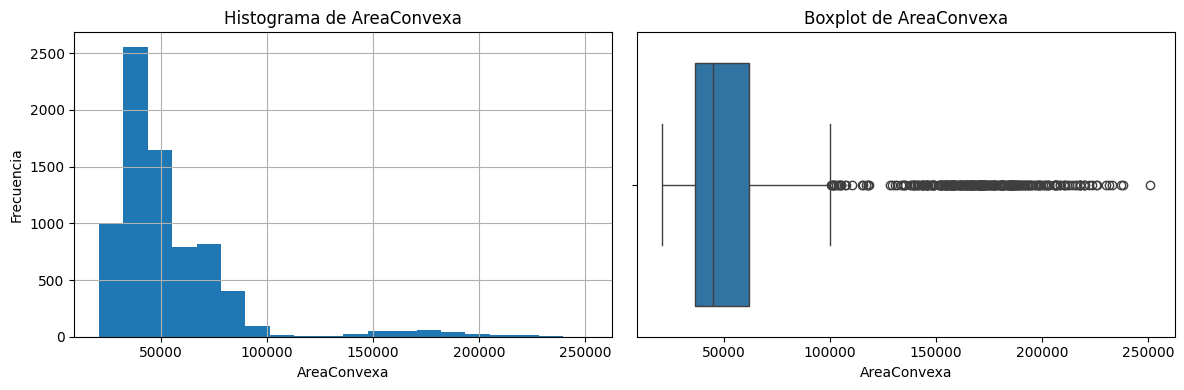

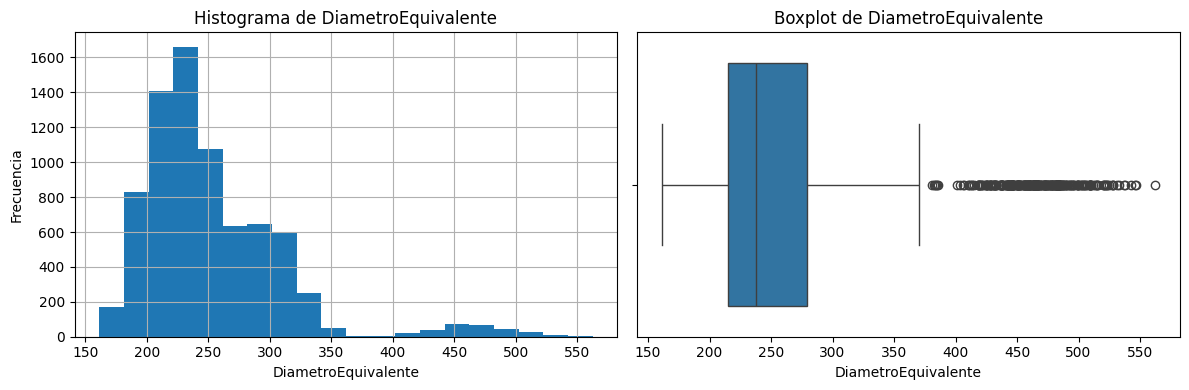

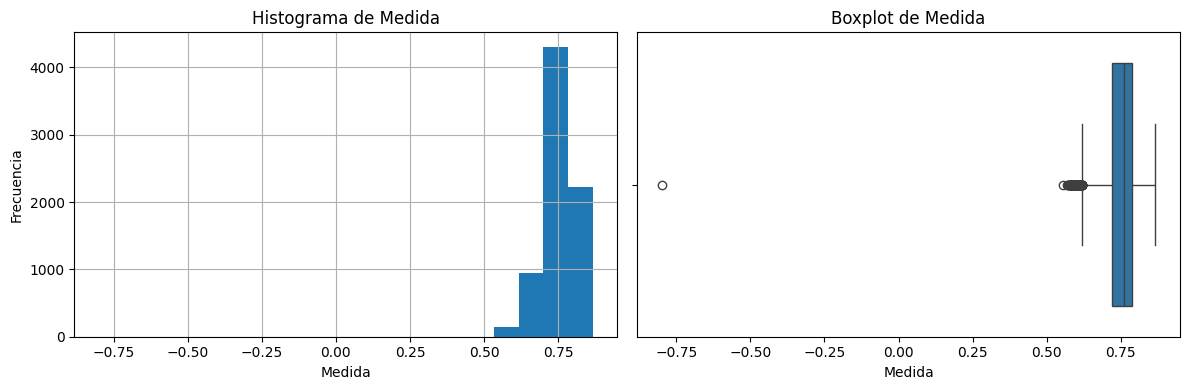

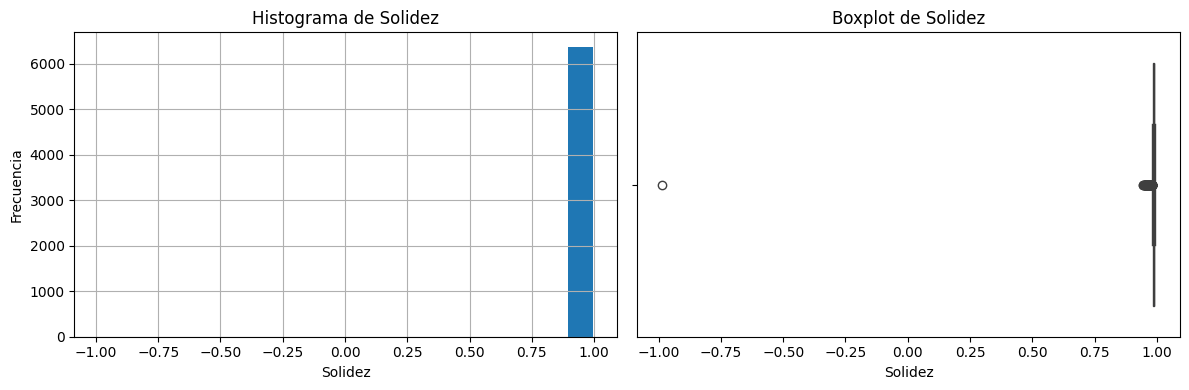

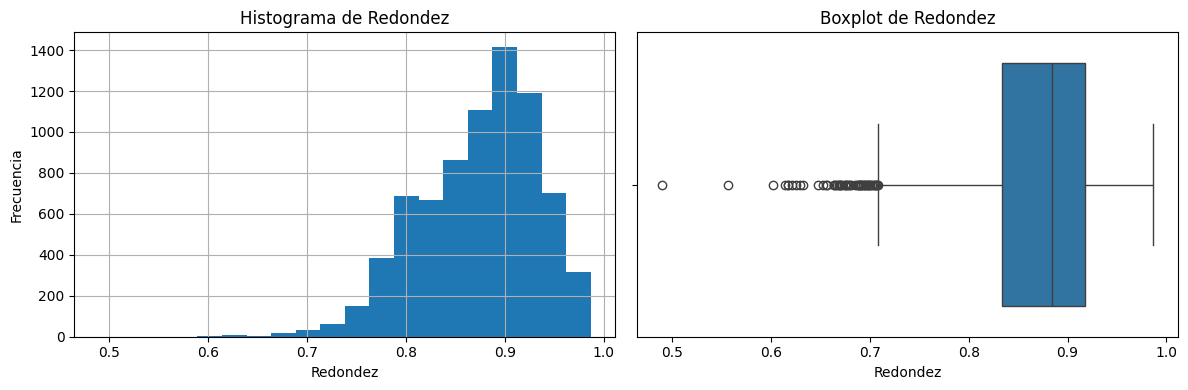

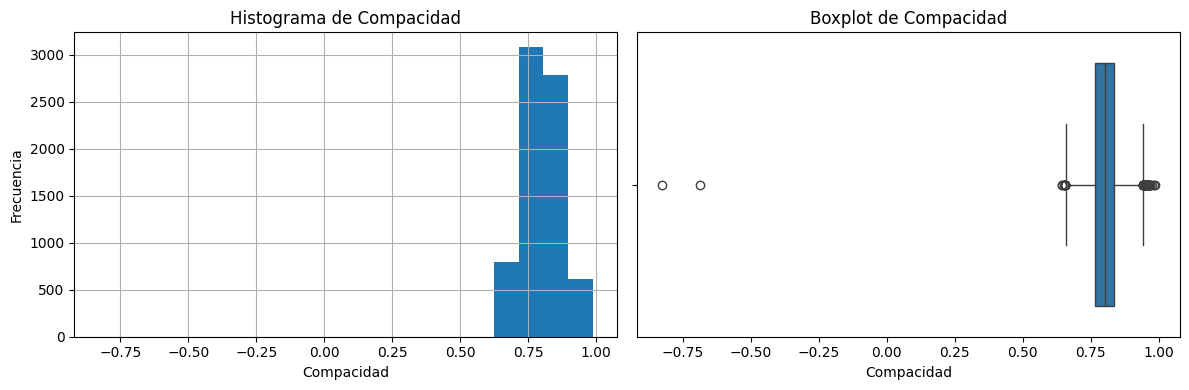

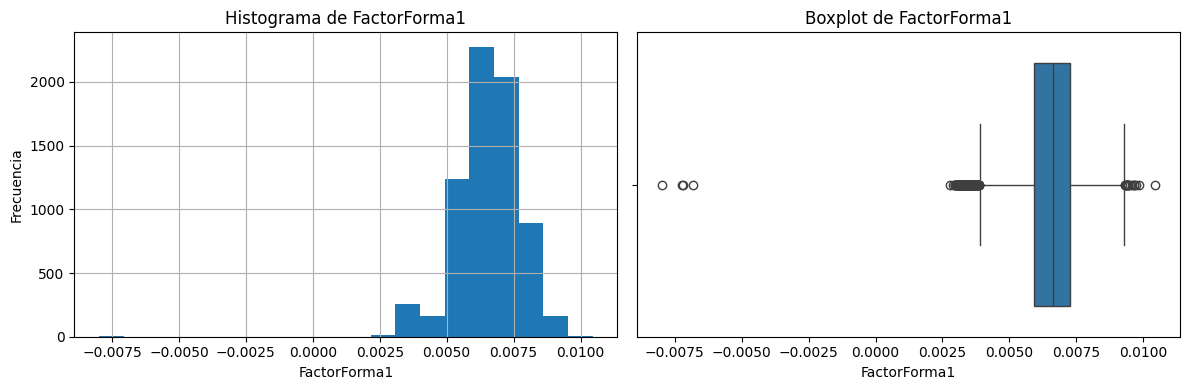

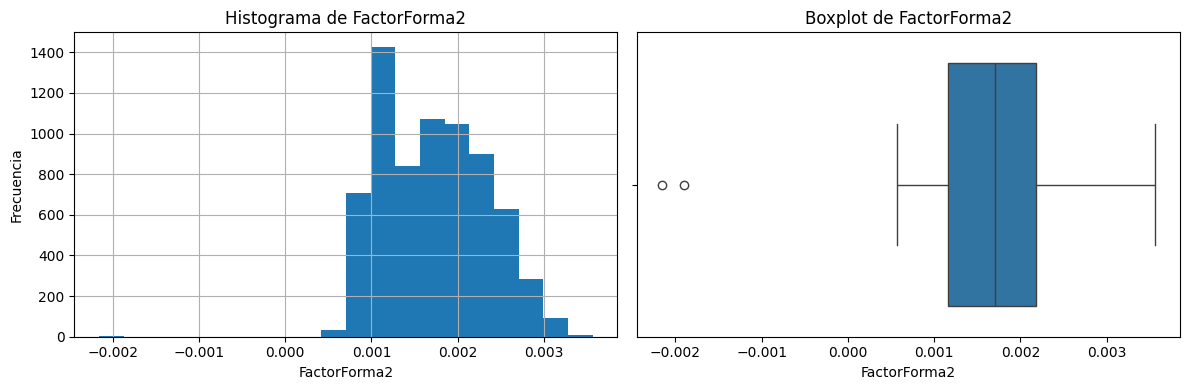

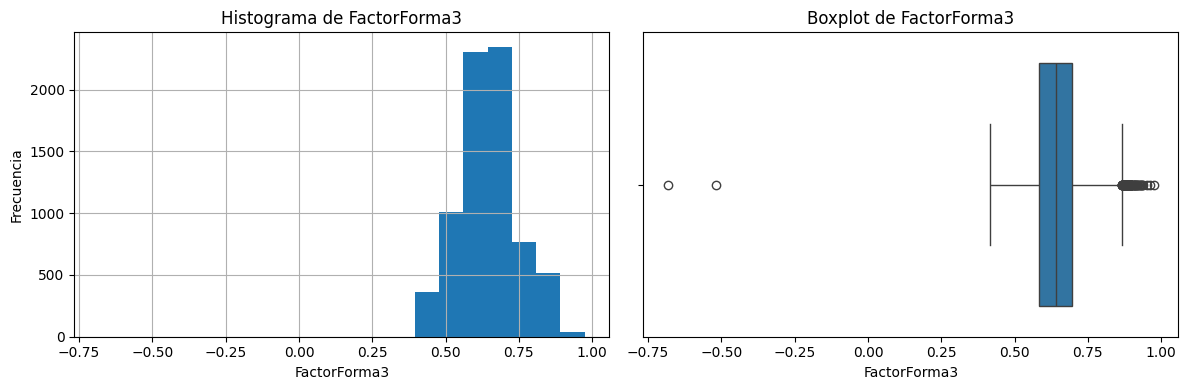

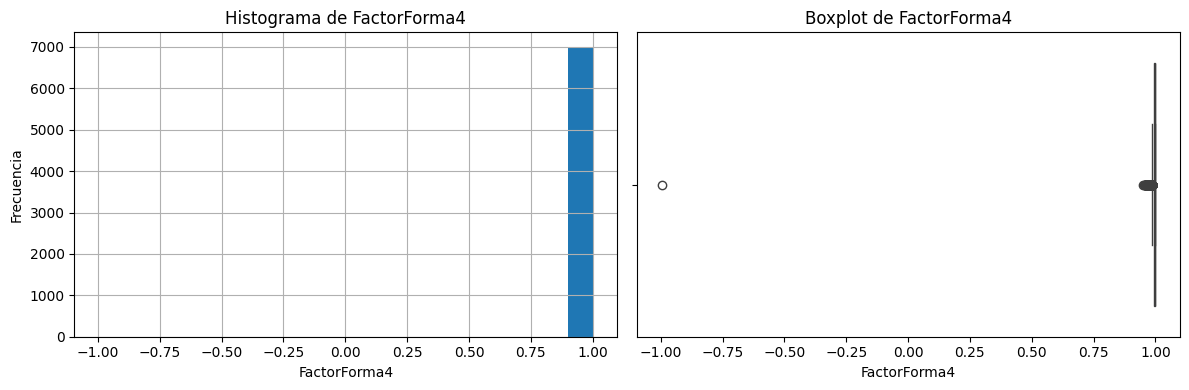

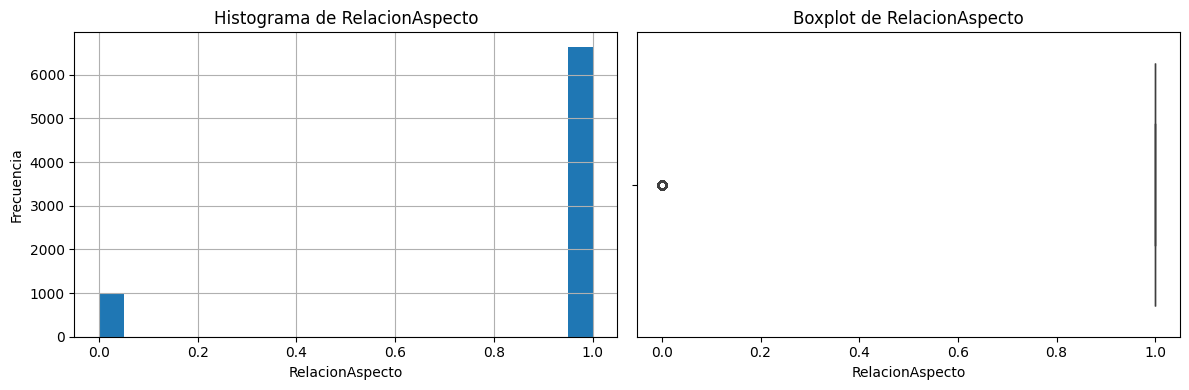

In [24]:
for col in numericas:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    df[col].dropna().hist(ax=axes[0], bins=20)
    axes[0].set_title(f"Histograma de {col}")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Frecuencia")

    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"Boxplot de {col}")
    axes[1].set_xlabel(col)

    plt.tight_layout()
    plt.show()


Podemos notar estas observaciones:

- **Escalas heterogéneas entre variables**
   Se identifican diferencias marcadas en las magnitudes: variables como Área, Perímetro, LongitudEjeMayor y ÁreaConvexa tienn valores  de miles, y si vemos hay  otras  como Solidez, Redondez, Compacidad, Medida y los Factores de forma están restringidas al rango [0, 1]. Esta disparidad confirma la necesidad de aplicar técnicas de escalado o normalización.

- **Distribuciones asimétricas y sesgos:**
   Muchas de las variables presentan sesgo positivo, como DiámetroEquivalente y  Área En contraste, las variables acotadas (Solidez, Redondez) muestran una concentración de valores en el extremo superior. 

   Ademas , se  evidencian en los boxplots abundantes valores extremos en la mayoría de las variables.





**Cosas a tener en cuenta con los modelos**

- Algoritmos sensibles a la escala y a outliers, como K-Means y Gaussian Mixture, requieren un preprocesamiento exhaustivo.


- El conjunto de datos analizado presenta heterogeneidad en las escalas de sus variables, distribuciones sesgadas y abundancia de valores atípicos. Estos aspectos deben ser abordados en la fase de preparación de los datos, ya que condicionan la validez y consistencia de los resultados obtenidos mediante técnicas de agrupación. 

A continuacion se realizara una matriz de correlacion para revisar que variables pueden estar siendo redundantes y poder reducir la dimensionalidad del modelo.

### 3.3.3 Matriz de correlacion
La matriz de correlación servirá para caracterizar la dependencia lineal entre variables y, a partir de ello,  optimizar el conjunto de características antes del agrupamiento. Sirve para reducir el ruido, evitar redundancias.

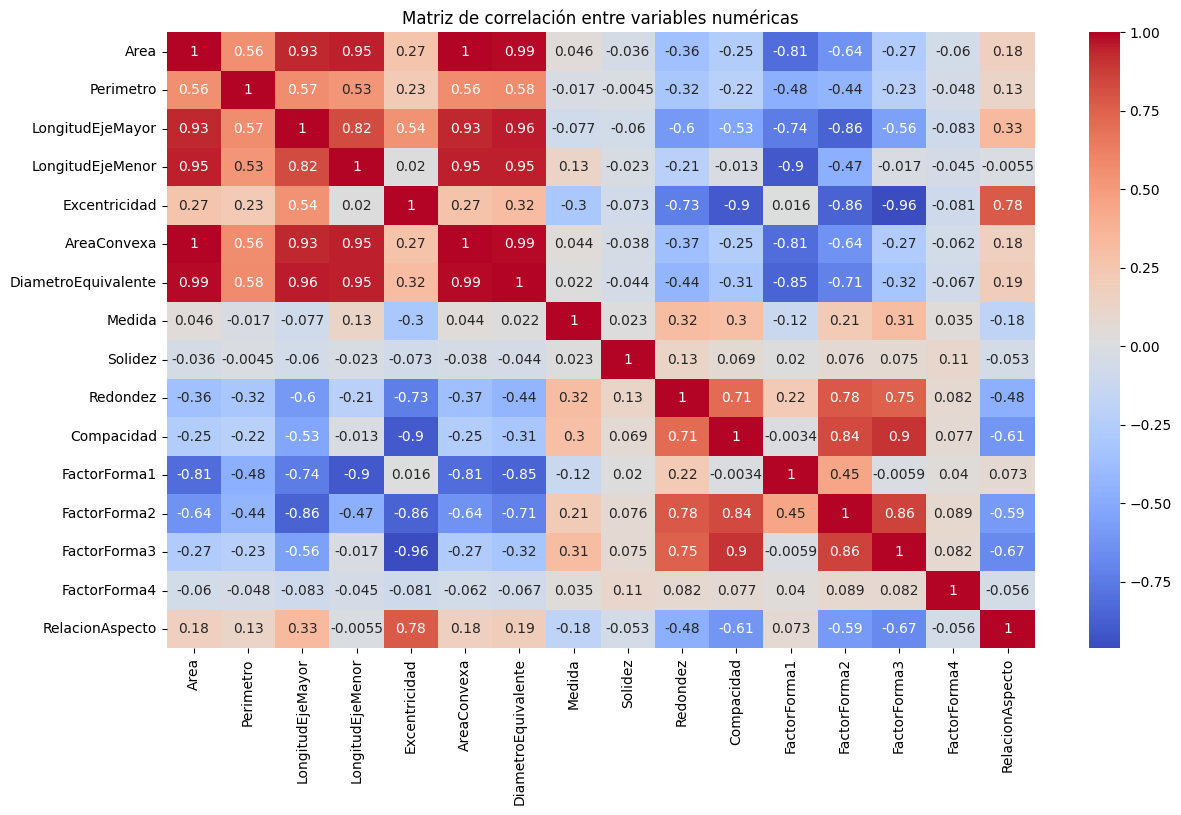

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = df[numericas].corr()
plt.figure(figsize=(14,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación entre variables numéricas')
plt.show()



**Alta multicolinealidad**

- Area, AreaConvexa y DiametroEquivalente tienen correlaciones casi perfectas (>0.95). Esto significa que llevan prácticamente la misma información → por lo que se dejara solo una de ellas.

- LongitudEjeMayor y LongitudEjeMenor también están muy correlacionadas con las anteriores.

**Variables redundantes**

Mantener todas esas variables fuertemente correlacionadas puede hacer que el clustering esté sesgado (porque esas dimensiones dominan la distancia).


**Variables con baja correlación con el bloque anterior**

Excentricidad, Redondez, Compacidad y Factores de forma aportan información distinta → estas suelen ser más valiosas para diferenciar clusters.

**Variables derivadas**

- FactorForma1, FactorForma2 y FactorForma3 están fuertemente correlacionadas entre sí (>0.8). Una sola puede ser representativa, o puedes hacer un PCA para capturar su variación.

Para la parte de entender la medida del cafe se decidio dejar Diametro Equivalente , ya que representa el tamaño globabl del grano de Cafe (todas las otras variables se representan aca)

Por lo que descartariamos las variables de Área, ÁreaConvexa, LongitudEjeMayor, LongitudEjeMenor → ya quedan representadas por DiámetroEquivalente (y en parte por Perímetro/Compacidad).

Para la parte FactorForma 1 ,2 y 3 se revisara mas a fondo.


## 3.4 Valores nulos

Se completaran los variables numericas para conservar la mayor cantidad posibles de muestras.  

**Variables Numericas**
    
    Se utilizará la mediana, que es robusta frente a valores atípicos.  

**Variables Categoricas**
    
    Para variables categóricas se eliminara los valores faltantes ya que es menos del 5%.  


In [26]:
from sklearn.impute import SimpleImputer


df_imp = df.copy()

num_cols = df_imp.select_dtypes(include=["float64", "int64"]).columns


imputer_num = SimpleImputer(strategy="median")
df_imp[num_cols] = imputer_num.fit_transform(df_imp[num_cols])

df_imp=df_imp.dropna()


print("Tamaño del dataset después de imputación:", df_imp.shape)
print("\nValores nulos restantes:")
print(df_imp.isna().sum().sort_values(ascending=False).head(10))


Tamaño del dataset después de imputación: (7616, 19)

Valores nulos restantes:
Area                   0
Perimetro              0
LongitudEjeMayor       0
LongitudEjeMenor       0
RelacionAspecto        0
Excentricidad          0
AreaConvexa            0
DiametroEquivalente    0
Medida                 0
Solidez                0
dtype: int64


### 3.4 Selección de variables relevantes


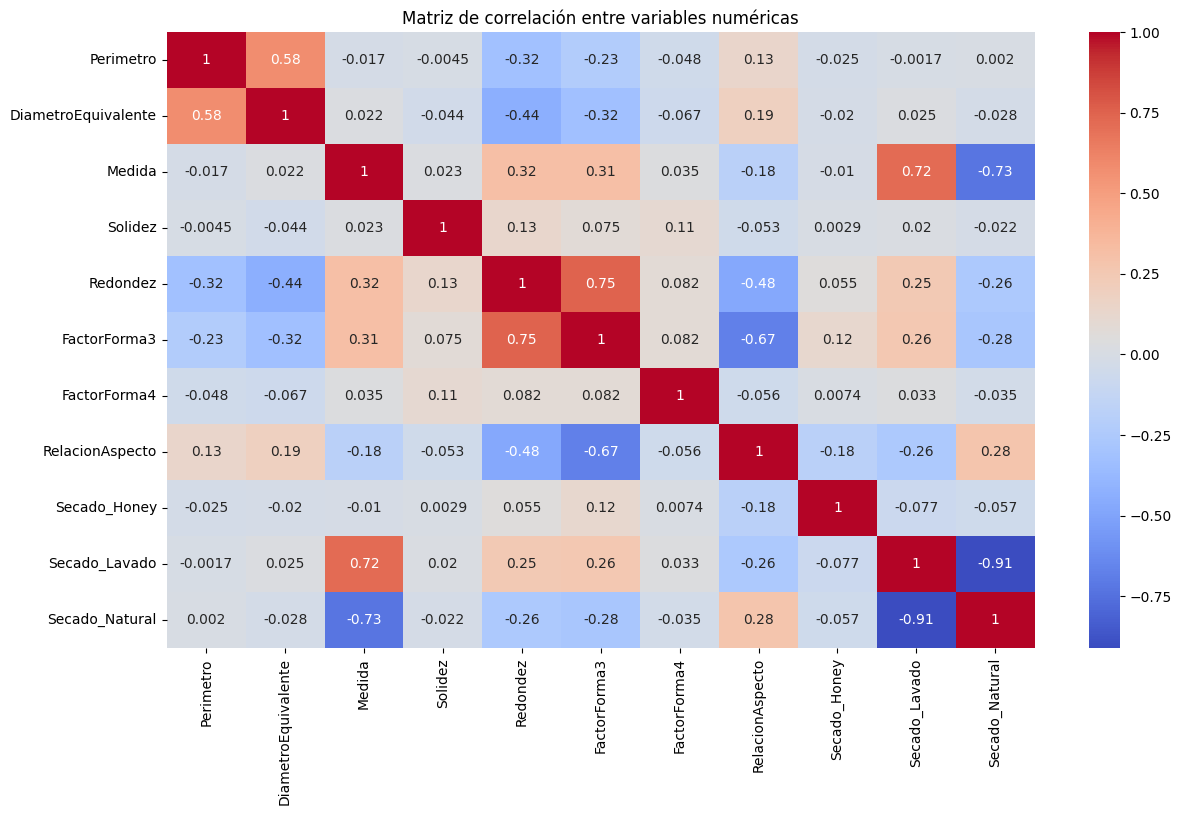

Variables seleccionadas: ['Perimetro', 'DiametroEquivalente', 'Medida', 'Solidez', 'Redondez', 'FactorForma3', 'FactorForma4', 'RelacionAspecto', 'Secado_Honey', 'Secado_Lavado', 'Secado_Natural']
Dimensiones de df_cluster: (7616, 11)


In [27]:
vars_modelo = [
    'Perimetro', 
    'DiametroEquivalente', 'Medida',
    'Solidez', 'Redondez',
    'FactorForma3', 'FactorForma4','RelacionAspecto','Secado_Honey','Secado_Lavado','Secado_Natural'
]

import seaborn as sns
import matplotlib.pyplot as plt
corr = df[vars_modelo].corr()
plt.figure(figsize=(14,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación entre variables numéricas')
plt.show()

vars_modelo = [v for v in vars_modelo if v in df_imp.columns]

df_cluster = df_imp[vars_modelo].copy()
print("Variables seleccionadas:", vars_modelo)
print("Dimensiones de df_cluster:", df_cluster.shape)


**Por qué estas variables**

**Tamaño y escala del grano**

Perímetro y DiámetroEquivalente capturan tamaño y una medida circular equivalente. Son menos redundantes que usar también Área, porque el diámetro ya sintetiza el área y Perímetro añade información de borde/contorno.

**Ocupación y regularidad del contorno**

Medida (ocupación del bounding box), Solidez (área/área convexa) y Redondez ((4πA)/P²) describen qué tan compacto y regular es el grano desde tres ángulos distintos (relleno de caja, convexidad y circularidad). En la matriz se ven correlaciones moderadas/altas (p. ej., Solidez–Redondez ≈0.62–0.77), pero no son equivalentes y aportan matices necesarios para separar morfologías.

**Rasgos de forma de mayor orden**

FactorForma3 y FactorForma4 condensan combinaciones no lineales de métricas básicas. Su inclusión mejora la capacidad de separación cuando las variables elementales no bastan (se observa correlación con Solidez/Redondez, pero no solapan completamente).

**Proporción geométrica clave**

RelaciónAspecto resume la elongación (eje mayor / eje menor) y es un criterio operativo de la empresa (Alargado vs Redondeado). Aporta un eje de variación distinto al de circularidad/compactación.

**Variable de dominio relevante**

Secado_Honey, Secado_Lavado, Secado_Natural incorporan el método de procesamiento, factor con impacto real en morfología y, sobre todo, en segmentación comercial y trazabilidad (alineado al objetivo de negocio). 

## 4. Entrenamiento de modelos

### 4.1 K-Means

El algoritmo K-Means es una técnica de agrupación que busca dividir los datos en subconjuntos homogéneos a partir de la proximidad a centros representativos (centroides). Para garantizar que todas las variables aporten de forma equilibrada al cálculo de distancias, primero se normalizan las características seleccionadas. Posteriormente, se entrenan modelos variando el número de grupos 𝐾 , con el fin de identificar la cantidad de clústeres que mejor describe la estructura de los datos.

#### 4.1.1 Escalado de datos


En esta celda se aplicó el escalado estandarizado (media = 0, desviación estándar = 1) a todas las variables numéricas seleccionadas. Esto garantiza que todas las variables tengan el mismo peso en el cálculo de distancias, evitando que las de mayor rango (como Área o Perímetro) dominen el clustering.


Para evitar que las variables categoricas convertidas  preserven su significado y evita que se distorsionen no se estandarizaran.

In [28]:

from sklearn.compose import ColumnTransformer


# Variables numericas
num_cols = ["Perimetro", "DiametroEquivalente", "Medida", 
            "Solidez", "Redondez", "FactorForma3", 
            "FactorForma4"]

cat_cols = ["Secado_Honey", "Secado_Lavado", "Secado_Natural","RelacionAspecto"]  # one-hot / binarias


preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),     # Escalar solo variables numericas
        ("cat", "passthrough", cat_cols)         # Columnas categoricas transformadas (one-hot,binarias)
    ]
)

# Ajustar y transformar df_cluster
df_cluster_scaled = preprocessor.fit_transform(df_cluster)
print("Dimensiones de df_cluster_scaled:", df_cluster_scaled.shape)


Dimensiones de df_cluster_scaled: (7616, 11)


#### 4.1.2 Número óptimo de clusters


En este paso se probó el algoritmo K-Means con distintos valores de 
𝐾 entre 2 y 20, utilizando el método del codo como criterio de evaluación.  El punto donde la curva comienza a estabilizarse indica la cantidad de clústeres más adecuada, al equilibrar simplicidad del modelo y capacidad de representar la estructura de los datos.


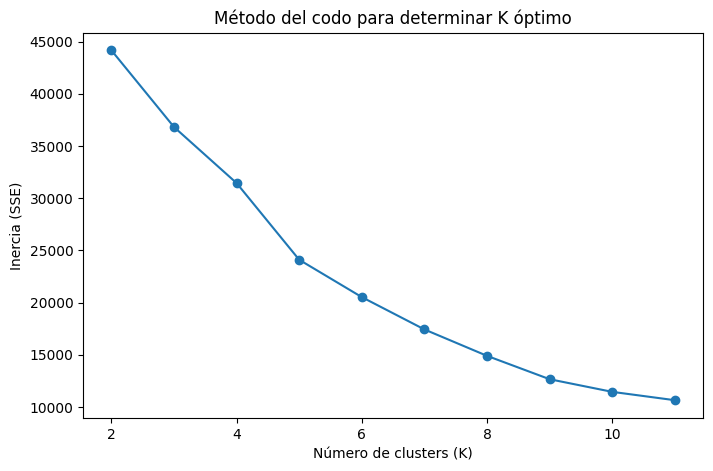

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k_values = range(2, 12)
inertia = []
sse = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_cluster_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, inertia, marker="o")
plt.title("Método del codo para determinar K óptimo")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inercia (SSE)")
plt.show()


La curva muestra un descenso progresivo y relativamente suave de la inercia, sin un quiebre claro que indique un número de clústeres evidente. Este patrón suele darse cuando los datos no presentan separaciones nítidas, sino una distribución más continua. En consecuencia, al incrementar 𝐾
la inercia disminuye de manera gradual, pero sin un punto de codo pronunciado. Para definir un valor de 𝐾 se utilizara otra metrica (Silhouette y Davies-Bouldin)

#### 4.1.4 Evaluación de K con Silhouette y Davies–Bouldin

Para complementar el método del codo se utilizan dos métricas adicionales:

- Coeficiente de Silueta: valores más altos indican clusters más compactos y mejor separados.  
- Índice de Davies–Bouldin: valores más bajos indican mejor desempeño de clustering.  


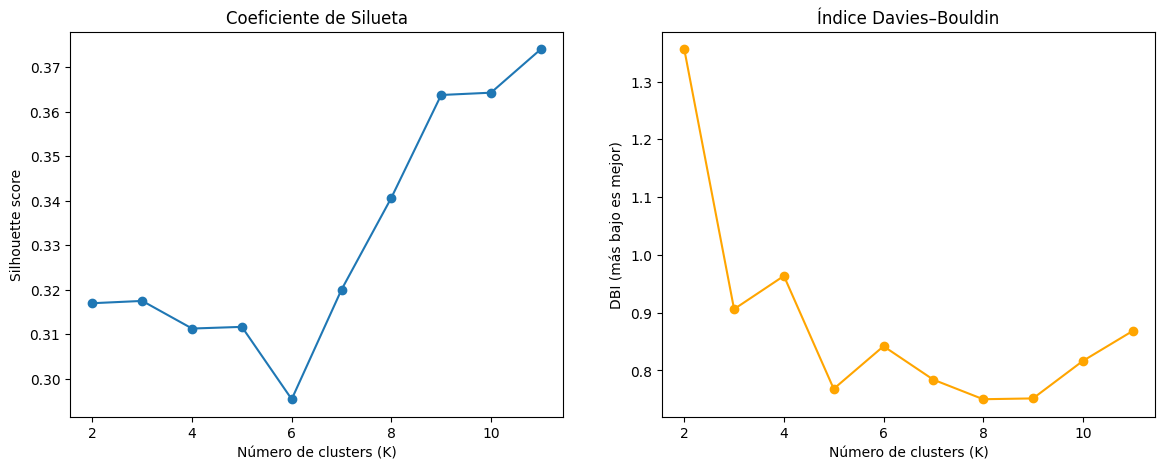

In [30]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

k_values = range(2, 12)
silhouette_scores = []
dbi_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_cluster_scaled)
    
    # Silhouette
    sil = silhouette_score(df_cluster_scaled, labels)
    silhouette_scores.append(sil)
    
    # DBI
    dbi = davies_bouldin_score(df_cluster_scaled, labels)
    dbi_scores.append(dbi)

# Graficar resultados
fig, axes = plt.subplots(1, 2, figsize=(14,5))

axes[0].plot(k_values, silhouette_scores, marker="o")
axes[0].set_title("Coeficiente de Silueta")
axes[0].set_xlabel("Número de clusters (K)")
axes[0].set_ylabel("Silhouette score")

axes[1].plot(k_values, dbi_scores, marker="o", color="orange")
axes[1].set_title("Índice Davies–Bouldin")
axes[1].set_xlabel("Número de clusters (K)")
axes[1].set_ylabel("DBI (más bajo es mejor)")

plt.show()


**Resumen de resultados y recomendación:**

**Silueta:** pico local en K=6 (~0.29) y luego sube suavemente hasta K=8 (~0.365); no hay salto claro → separación moderada, mejoras marginales al aumentar K.

**Davies–Bouldin (DBI):** mínimo en K=8 (~0.76); a partir de ahí se mantiene casi plano (ligeras subidas/bajadas).

Por lo que se ve ,K=8 es el candidato principal: mejor DBI y silueta aceptable, buen equilibrio entre compactación y separación sin sobrefragmentar.



### 4.2 DBSCAN
DBSCAN es un algortimo de agrupación, el cual agrupa los puntos en función de la densidad. Se forman los clusters en regiones densas, y las menos densas se consideran outliers. Hace uso de 2 parámetros, los cuales son el radio de la vecindad y el número minimo de puntos necesarios para considerar la región como densa.

#### 4.2.1 Escalado de datos
En esta celda se aplicó el escalado estandarizado (media = 0, desviación estándar = 1) a todas las variables numéricas seleccionadas. Esto garantiza que todas las variables tengan el mismo peso en el cálculo de distancias, evitando que las de mayor rango (como Área o Perímetro) dominen el clustering.

Para evitar que las variables categoricas convertidas  preserven su significado y evita que se distorsionen no se estandarizaran.

In [31]:
from sklearn.preprocessing import StandardScaler


# Variables numericas
num_cols = ["Perimetro", "DiametroEquivalente", "Medida", 
            "Solidez", "Redondez", "FactorForma3", 
            "FactorForma4"]

cat_cols = ["Secado_Honey", "Secado_Lavado", "Secado_Natural","RelacionAspecto"]  # one-hot / binarias


preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),     # Escalar solo variables numericas
        ("cat", "passthrough", cat_cols)         # Columnas categoricas transformadas (one-hot,binarias)
    ]
)

# Ajustar y transformar df_cluster
df_cluster_scaled = preprocessor.fit_transform(df_cluster)
print("Dimensiones de df_cluster_scaled:", df_cluster_scaled.shape)



Dimensiones de df_cluster_scaled: (7616, 11)


#### 4.2. Busqueda de mejor eps (metodo del codo)

Para el método del codo para DBSCAN, no se hace uso de la inercia (se utiliza solo para el K-means), sino que se usa la distancia k-vecinos más cercanos. En este caso, se utilizó un min_samples igual a 4.

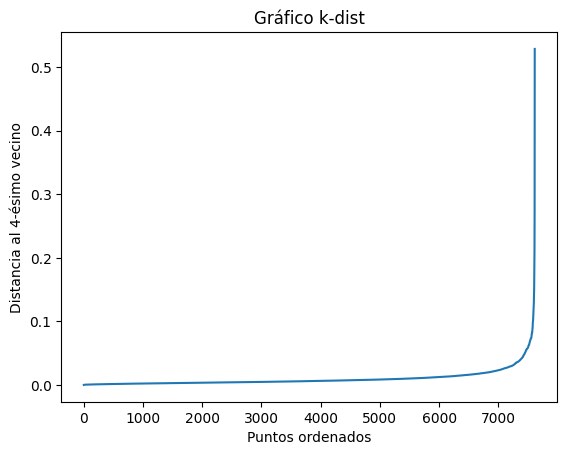

In [32]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

k = 4  # igual a min_samples
nn = NearestNeighbors(n_neighbors=k, metric="cosine")
nn.fit(df_cluster_scaled)
distances, indices = nn.kneighbors(df_cluster_scaled)

# Tomamos la distancia al k-ésimo vecino
dist_k = np.sort(distances[:, -1])

plt.plot(dist_k)
plt.ylabel(f"Distancia al {k}-ésimo vecino")
plt.xlabel("Puntos ordenados")
plt.title("Gráfico k-dist")
plt.show()

In [33]:
#!pip install kneed

In [34]:
from kneed import KneeLocator

kneedle = KneeLocator(range(len(dist_k)), dist_k, S=1.0, curve="convex", direction="increasing")
eps_optimo = dist_k[kneedle.knee]
print("eps sugerido:", eps_optimo)

eps sugerido: 0.08245367925532265


Al realizar la busqueda del eps optimo con el metodo del codo, daba error al hacer el DBSCAN. Esto debido a que el eps arrojado no era el mejor, por lo que se cambió la metrica a coseno. Al hacer esto, el eps optimo arrojado es de 0.12 aproximadamente. Este valor se extrajo del codo de las distancias de los k-vecinos más cercanos.

#### 4.3 Busqueda del mejor min_samples (métricas de evaluación de clustering)
Para hallar el mejor min_samples se usaron las siguientes métricas:

- Coeficiente de Silueta: valores más altos indican clusters más compactos y mejor separados.  
- Índice de Davies–Bouldin: valores más bajos indican mejor desempeño de clustering. 
- Índice de Calinski-Harabasz: valores más altos indicam clusteres mejor separados

Text(0, 0.5, 'Silhouette score')

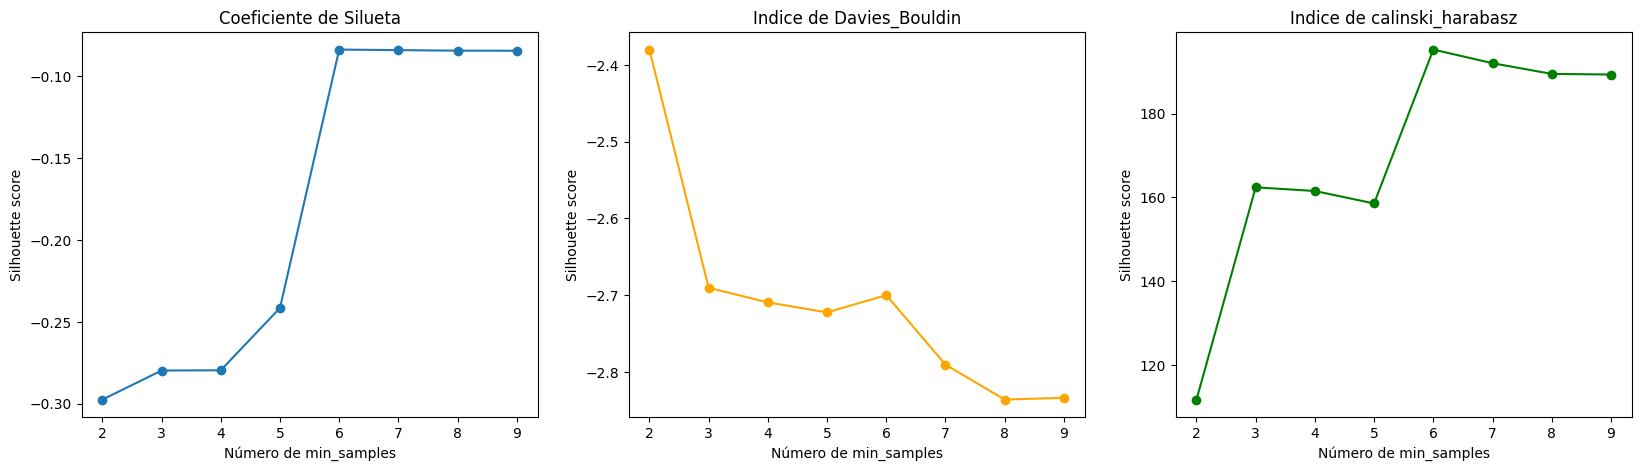

In [35]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

min_samples_values = range(2, 10)

silhouette_scores = []
dbi_scores = []
calinski_scores = []

for min_sample in min_samples_values:
    # Probando con eps fijo, pero min_samples variable
    db = DBSCAN(eps=0.08, min_samples=min_sample, metric="cosine").fit(df_cluster_scaled)
    labels = db.labels_
    
    # Evitar casos con 1 solo cluster o todo ruido
    if len(set(labels)) <= 1 or len(set(labels)) == 2 and -1 in labels:
        continue
    
    try:
        sil = silhouette_score(df_cluster_scaled, labels)
        dav = -davies_bouldin_score(df_cluster_scaled, labels)
        cal = calinski_harabasz_score(df_cluster_scaled, labels)
        silhouette_scores.append(sil)
        dbi_scores.append(dav)
        calinski_scores.append(cal)
    except:
        continue

fig, axes = plt.subplots(1, 3, figsize=(20,5))
axes[0].plot(min_samples_values, silhouette_scores, marker="o")
axes[0].set_title("Coeficiente de Silueta")
axes[0].set_xlabel("Número de min_samples")
axes[0].set_ylabel("Silhouette score")

axes[1].plot(min_samples_values, dbi_scores, marker="o", color="orange")
axes[1].set_title("Indice de Davies_Bouldin")
axes[1].set_xlabel("Número de min_samples")
axes[1].set_ylabel("Silhouette score")

axes[2].plot(min_samples_values, calinski_scores, marker="o", color="green")
axes[2].set_title("Indice de calinski_harabasz")
axes[2].set_xlabel("Número de min_samples")
axes[2].set_ylabel("Silhouette score")

- Los min-samples más optimos en silueta, son los que generan un score más alto, siendo estos de 6 a 9 min-samples con un resultado de ~ -0.8.
- Los min-samples más optimos en Davies-Bouldin, son los que generan un score más bajo, siendo estos 8 a 9 con un resultado de ~ -2.83.
- Los min-samples más optimos en Calinski-Harabaz, son los que generan un score más alto, siendo 6 con un resultado de ~ 200.

Por lo que los min-samples más optimos estarían entre 6 y 9. Estos resultados dan un cluster más compacto, con mejor separación y mejor desempeño, espcialmente 8.

### 4.3 Modelo 3: Gaussian Mixture Models (GMM)

Objetivo: detectar agrupaciones elípticas y con diferente varianza, además de obtener probabilidades de pertenencia para apoyar decisiones de calidad y trazabilidad.

#### 4.3.1 Escalado de datos


In [36]:
from sklearn.preprocessing import StandardScaler

# Escalamos las variables finales seleccionadas para clustering
scaler_gmm = StandardScaler()
X_scaled_gmm = scaler_gmm.fit_transform(df_cluster)


#### 4.3.2 Selección de hiperparámetros (n_components y covariance_type) con BIC/AIC

In [37]:
from sklearn.mixture import GaussianMixture

componentes = range(2, 11)              # probar entre 2 y 10 clusters
cov_types = ['full', 'tied', 'diag', 'spherical']

resultados = []
for cov in cov_types:
    for k in componentes:
        gmm = GaussianMixture(n_components=k, covariance_type=cov, random_state=42, n_init=5)
        gmm.fit(X_scaled_gmm)
        resultados.append({
            'covariance_type': cov,
            'n_components': k,
            'bic': gmm.bic(X_scaled_gmm),
            'aic': gmm.aic(X_scaled_gmm)
        })

df_result = pd.DataFrame(resultados)
df_bic = df_result.sort_values('bic')
df_aic = df_result.sort_values('aic')

print("Top 5 configuraciones según BIC:")
display(df_bic.head())
print("Top 5 configuraciones según AIC:")
display(df_aic.head())

best_conf = df_bic.iloc[0]
best_cov = best_conf['covariance_type']
best_k   = int(best_conf['n_components'])
print(f"Mejor configuración por BIC -> covariance_type={best_cov}, n_components={best_k}")


Top 5 configuraciones según BIC:


,covariance_type,n_components,bic,aic
7,full,9,-289618.699282,-294482.241893
8,full,10,-287476.658335,-292881.365458
6,full,8,-278701.418005,-283023.796102
5,full,7,-277740.491961,-281521.705545
26,diag,10,-261958.409230,-263547.212736


Top 5 configuraciones según AIC:


,covariance_type,n_components,bic,aic
7,full,9,-289618.699282,-294482.241893
8,full,10,-287476.658335,-292881.365458
6,full,8,-278701.418005,-283023.796102
5,full,7,-277740.491961,-281521.705545
3,full,5,-261830.975813,-264529.860372


Mejor configuración por BIC -> covariance_type=full, n_components=9


El análisis de BIC y AIC mostró que la mejor configuración para el modelo GMM es con 9 componentes y covarianza tipo “full”. Esto indica que el conjunto de datos se ajusta mejor cuando se permite que cada grupo tenga una matriz de covarianza completa (es decir, que se consideren correlaciones entre variables dentro de cada cluster). El hecho de que tanto BIC como AIC coincidan en esta configuración da confianza sobre la robustez del número de clusters seleccionado.

#### 4.3.3 Entrenamiento final y asignación de clusters

In [38]:
gmm_final = GaussianMixture(
    n_components=best_k,
    covariance_type=best_cov,
    random_state=42,
    n_init=10
)
gmm_final.fit(X_scaled_gmm)

labels_gmm = gmm_final.predict(X_scaled_gmm)
proba_gmm = gmm_final.predict_proba(X_scaled_gmm)
confianza = proba_gmm.max(axis=1)

print("Distribución de tamaños por cluster (GMM):")
print(pd.Series(labels_gmm).value_counts().sort_index())


Distribución de tamaños por cluster (GMM):
0     940
1     273
2    2828
3    2392
4      37
5       1
6       1
7     940
8     204
Name: count, dtype: int64


La mayoría de los datos se concentran en unos pocos clusters grandes (por ejemplo, el cluster 2 con 2.828 granos y el cluster 3 con 2.392), mientras que existen algunos grupos muy pequeños o casi vacíos (por ejemplo, clusters 5 y 6 con solo un grano cada uno). Esto sugiere que la población de granos presenta varias formas dominantes y algunos casos atípicos que el modelo identifica como grupos separados, lo cual puede ser útil para detectar lotes inusuales o anómalos.

#### 4.3.4 Validación cuantitativa (métricas internas)


In [39]:

def safe_metric(func, X, labels):
    try:
        return func(X, labels)
    except:
        return np.nan

sil_gmm  = safe_metric(silhouette_score, X_scaled_gmm, labels_gmm)
dbi_gmm  = safe_metric(davies_bouldin_score, X_scaled_gmm, labels_gmm)
ch_gmm   = safe_metric(calinski_harabasz_score, X_scaled_gmm, labels_gmm)

print(f"Silhouette (↑): {sil_gmm:.3f}")
print(f"Davies-Bouldin (↓): {dbi_gmm:.3f}")
print(f"Calinski-Harabasz (↑): {ch_gmm:.1f}")


Silhouette (↑): 0.319
Davies-Bouldin (↓): 1.294
Calinski-Harabasz (↑): 2071.8


#### Visualización rápida con PCA 2D

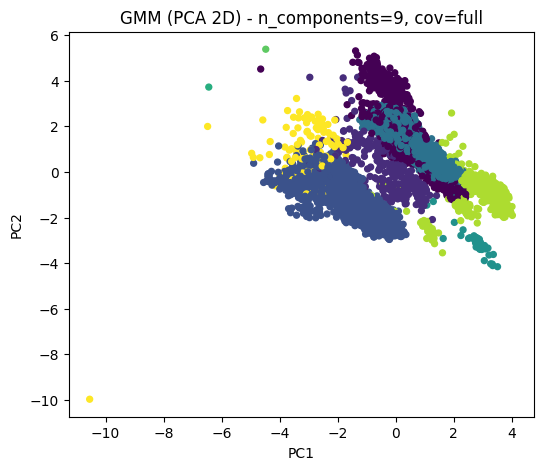

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_scaled_gmm)

plt.figure(figsize=(6,5))
plt.scatter(Z[:,0], Z[:,1], c=labels_gmm, s=18, cmap='viridis')
plt.title(f"GMM (PCA 2D) - n_components={best_k}, cov={best_cov}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


El modelo GMM alcanzó un coeficiente de silueta de 0.319, un Davies–Bouldin de 1.29 y un Calinski–Harabasz de 2.071. Estos valores indican una separación aceptable pero no tan clara entre grupos. En comparación con K-Means (que obtuvo una silueta de 0.416 y mejor Davies–Bouldin), GMM genera clusters más flexibles pero con una definición algo menor. Aun así, el modelo aporta un enfoque probabilístico que permite manejar la incertidumbre en los límites entre grupos.

#### 4.3.5 Interpretación cualitativa de los grupos

In [41]:
df_gmm = df_cluster.copy()
df_gmm["_cluster_gmm"] = labels_gmm

resumen = df_gmm.groupby("_cluster_gmm").mean().round(3)
print("Medias por cluster (GMM):")
display(resumen)


Medias por cluster (GMM):


,Perimetro,DiametroEquivalente,Medida,Solidez,Redondez,FactorForma3,FactorForma4,RelacionAspecto,Secado_Honey,Secado_Lavado,Secado_Natural
_cluster_gmm,,,,,,,,,,,
0,782587.380,317.510,0.786,0.985,0.838,0.623,0.993,1.0,0.0,1.000,0.000
1,793433.868,260.817,0.748,0.987,0.863,0.621,0.995,1.0,0.0,0.000,0.000
2,744502.667,245.649,0.704,0.987,0.859,0.611,0.995,1.0,0.0,0.000,1.000
3,805842.844,240.312,0.786,0.988,0.884,0.630,0.996,1.0,0.0,1.000,0.000
4,653287.582,235.747,0.743,0.988,0.920,0.818,0.997,0.0,1.0,0.000,0.000
5,780551.000,234.114,0.703,0.990,0.888,0.660,-0.996,1.0,0.0,0.000,1.000
6,875.330,249.803,0.783,-0.987,0.804,0.500,0.996,1.0,0.0,1.000,0.000
7,656802.833,223.009,0.776,0.990,0.948,0.815,0.998,0.0,0.0,0.919,0.045
8,1144646.221,326.866,0.695,0.978,0.792,0.584,0.985,1.0,0.0,0.005,0.995


La tabla de medias permite interpretar cada cluster morfológicamente.

- Algunos grupos (por ejemplo, cluster 0 y 8) destacan por perímetros y diámetros grandes, indicando granos más grandes.

- Otros, como los clusters 2 y 3, tienen valores más bajos de diámetro y perímetro, representando granos más pequeños.

- Las variables de forma como Solidez y Redondez muestran que la mayoría de clusters tienen granos bien formados (valores cercanos a 1), mientras que factores como FactorForma3/4 ayudan a diferenciar sutiles variaciones de contorno.

- El método de secado también varía: algunos clusters se asocian claramente con un tipo de secado específico (por ejemplo, el cluster 4 tiene valor 1 en Honey; los clusters 0 y 3 están ligados a Lavado).

Esta información puede apoyar la clasificación automática de granos y la creación de mezclas consistentes para la empresa.

## 5. Analisis de los resultados obtenidos

A continuación se realiza una comparación entre los resultados de las métricas para evaluar la clusterización.

In [ ]:
from sklearn.cluster import KMeans, DBSCAN

kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled_gmm)

dbscan = DBSCAN(eps=2, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled_gmm)

def compute_scores(X, labels, name):
    return {
        'modelo': name,
        'silhouette': safe_metric(silhouette_score, X, labels),
        'davies_bouldin': safe_metric(davies_bouldin_score, X, labels),
        'calinski_harabasz': safe_metric(calinski_harabasz_score, X, labels),
        'n_clusters': len(np.unique(labels))
    }

tabla = [
    compute_scores(X_scaled_gmm, labels_kmeans, 'KMeans'),
    compute_scores(X_scaled_gmm, labels_dbscan, 'DBSCAN'),
    compute_scores(X_scaled_gmm, labels_gmm, 'GMM')
]

df_comp = pd.DataFrame(tabla)
print("\nComparación de métricas entre modelos:")
display(df_comp.sort_values('silhouette', ascending=False))



Comparación de métricas entre modelos:


,modelo,silhouette,davies_bouldin,calinski_harabasz,n_clusters
0,KMeans,0.416212,0.660584,3554.518161,9
1,DBSCAN,0.322433,2.371207,1053.256264,8
2,GMM,0.318804,1.294392,2071.814872,9


Al revisar los resultados obtenidos se nos arrojan las siguientes conclusiones:
- Mejor Silhouette (Entre más alto mejor): KMeans con 0.416, lo que indica mejor separación y cohesión de clústeres.
- Mejor Davies-Bouldin (Entre más bajo mejor): KMeans con 0.661, lo que indica menor solapamiento entre clústeres.
- Mejor Calinski-Harabasz (Entre más alto mejor): KMeans con 3554.518, lo que indica una mejor densidad y separación entre clústers.

Teniendo en cuenta los resultados obtenidos, la opción con mejor modelo de agrupación para el caso de SeneCaféAlpes, sería KMeans. Por lo tanto el modelo recomendable y a escoger para este caso es KMeans.